# Importing Dependencies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
# import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Visualising the Dataset

In [2]:
data_path = "/kaggle/input/plant-village-dataset-updated/Apple"

In [3]:
import os

def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

walk_through_dir(data_path)

There are 3 directories and 0 images in '/kaggle/input/plant-village-dataset-updated/Apple'.
There are 4 directories and 0 images in '/kaggle/input/plant-village-dataset-updated/Apple/Val'.
There are 0 directories and 451 images in '/kaggle/input/plant-village-dataset-updated/Apple/Val/Healthy'.
There are 0 directories and 453 images in '/kaggle/input/plant-village-dataset-updated/Apple/Val/Apple Scab'.
There are 0 directories and 396 images in '/kaggle/input/plant-village-dataset-updated/Apple/Val/Cedar Apple Rust'.
There are 0 directories and 447 images in '/kaggle/input/plant-village-dataset-updated/Apple/Val/Black Rot'.
There are 4 directories and 0 images in '/kaggle/input/plant-village-dataset-updated/Apple/Test'.
There are 0 directories and 51 images in '/kaggle/input/plant-village-dataset-updated/Apple/Test/Healthy'.
There are 0 directories and 51 images in '/kaggle/input/plant-village-dataset-updated/Apple/Test/Apple Scab'.
There are 0 directories and 44 images in '/kaggle/inp

In [4]:
base_ds ='/kaggle/input/plant-village-dataset-updated/Apple/Train'
base_ds = pathlib.Path(base_ds)

In [5]:
Apple_Scab = [fn for fn in os.listdir(f'{base_ds}/Apple Scab') if (fn.endswith('.JPG') or fn.endswith('.jpeg'))]
Cedar_Apple_Rust = [fn for fn in os.listdir(f'{base_ds}/Cedar Apple Rust') if (fn.endswith('.JPG')  or fn.endswith('.jpeg'))]
Black_Rot= [fn for fn in os.listdir(f'{base_ds}/Black Rot') if (fn.endswith('.JPG')  or fn.endswith('.jpeg'))]
Healthy= [fn for fn in os.listdir(f'{base_ds}/Healthy') if (fn.endswith('.JPG')  or fn.endswith('.jpeg'))]

apple = [Healthy,Apple_Scab,Cedar_Apple_Rust,Black_Rot]
apple_classes = []
for i in os.listdir('/kaggle/input/plant-village-dataset-updated/Apple/Train'):
    apple_classes +=[i]
    apple_classes.sort()


Total images: 7771
Total number of classes: 4
Total Apple Scab images: 2008
Total Black Rot images: 2016
Total Cedar Apple Rust images: 1760
Total Healthy images: 1987


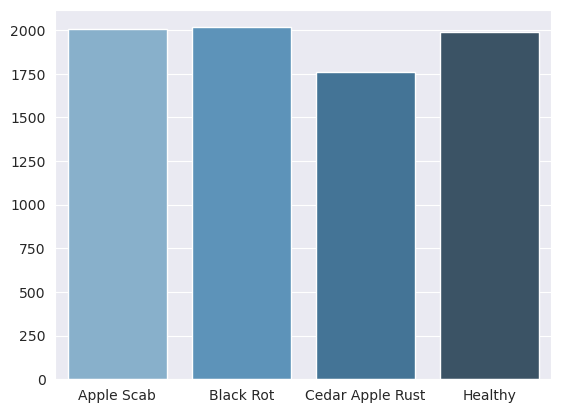

In [6]:
image_count1= len(list(base_ds.glob('*/*.JPG')))
image_count2 = len(list(base_ds.glob('*/*.jpeg')))
image_count=image_count1+image_count2
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(apple_classes)}')
count = 0
apple_count = []
for x in apple_classes:
    print(f'Total {x} images: {len(apple[count])}')
    apple_count.append(len(apple[count]))
    count+=1
sns.set_style('darkgrid')
sns.barplot(x=apple_classes, y=apple_count, palette="Blues_d")
plt.show()

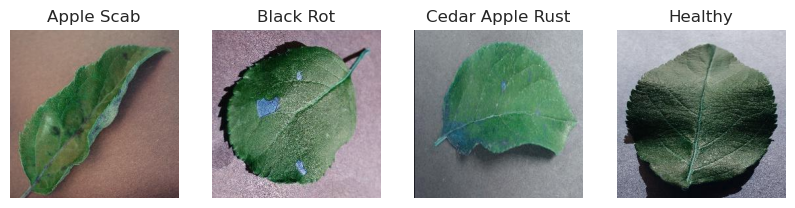

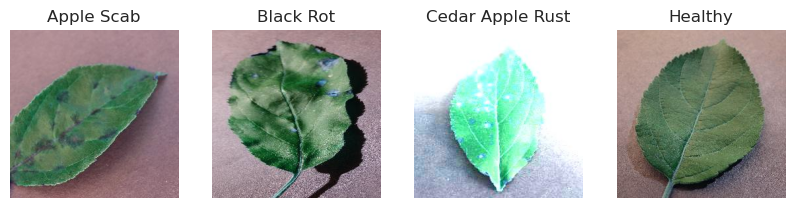

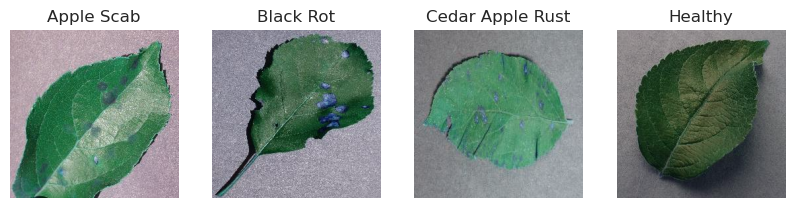

In [7]:
def load_random_img(dir, label):
    plt.figure(figsize=(10,10))
    i=0
    for label in apple_classes:
        i+=1
        plt.subplot(1,4, i)
        file = random.choice(os.listdir(f'{dir}/{label}'))
        image_path = os.path.join(f'{dir}/{label}', file)
        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')
for i in range(3):
       load_random_img(base_ds,apple_classes)


# Data Augmentation

In [8]:
train_path = "/kaggle/input/plant-village-dataset-updated/Apple/Train"
val_path = "/kaggle/input/plant-village-dataset-updated/Apple/Val"
test_path = "/kaggle/input/plant-village-dataset-updated/Apple/Test"

In [9]:
batch_size = 32
img_height = 224

train_datagen = ImageDataGenerator(
  rescale = 1./255.,
  rotation_range=20,
  shear_range=0.15,
  horizontal_flip=True,

)

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)


def generate_generator_multiple_train(generator,dir1,batch_size, img_height,img_width):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=True,
                                          seed=42)

    while True:
            X1i = genX1.next()
            yield [X1i[0],X1i[0]], X1i[1]
            
def generate_generator_multiple_test(generator,dir1,batch_size, img_height,img_width):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=False,
                                          seed=42)

    while True:
            X1i = genX1.next()
            yield [X1i[0],X1i[0]], X1i[1]



inputgenerator=generate_generator_multiple_train(train_datagen,
                                           dir1=train_path,
                                           batch_size=batch_size,
                                           img_height=img_height,
                                           img_width=img_height)

valgenerator = generate_generator_multiple_test(val_datagen,
                                            dir1 = val_path,
                                            batch_size = batch_size,
                                            img_height = img_height,
                                            img_width = img_height)

# testgenerator=generate_generator_multiple_test(test_datagen,
#                                           dir1=test_path,
#                                           batch_size=batch_size,
#                                           img_height=img_height,
#                                           img_width=img_height)

train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224,224),
                                                 batch_size = 64,
                                                 shuffle = True,
                                                 class_mode = 'categorical')


val_set = val_datagen.flow_from_directory(val_path,
                                                target_size = (224, 224),
                                                 batch_size = 32,
                                                 shuffle = False,
                                                 class_mode = 'categorical')



Found 7771 images belonging to 4 classes.
Found 1747 images belonging to 4 classes.


# Model Creation
    
**Model has been taken from [Tensorflow Hub](https://tfhub.dev/sayakpaul/collections/vision_transformer/1)**

- **ViT-r50-l32-Fe Vision Transformer:**
  - A member of the ViT model family that combines ResNet-50 and ViT architectures.
  - Utilizes a ResNet-50 backbone followed by a ViT for image processing.
  - Embeds spatial output from ResNet into ViT's initial patch embeddings.

- **ResNet-50 Architecture:**
  - Incorporates 50 residual blocks (R50) for intricate pattern learning.
  - Enables the model to capture complex features and representations.
  
- **Patch Size "L32":**
  - Refers to a 32x32 patch size used in the ViT.
  - Facilitates the capture of long-range dependencies and contextual information.

- **ImageNet-21k Training:**
  - The model is fine-tuned on ImageNet-21k dataset.
  - Images are resized to 224x224 resolution.
  - Pixel values are within the range of [-1, 1].

- **Performance:**
  - Achieved a top-1 accuracy of 83.78% on ImageNet-21k validation set.
  - Demonstrates the model's ability to understand and recognize diverse visual patterns.

- **Hybrid Strengths:**
  - The hybrid design combines the advantages of both ResNet and Transformer architectures.
  - Makes it an appealing choice for advanced visual recognition tasks.

**1. Patch Visualization**

In [10]:
image_size = 224 
img_height, img_width = 512, 512
patch_size = 32
num_patches = (image_size // patch_size) ** 2

In [11]:
 class Patches(layers.Layer):
    
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


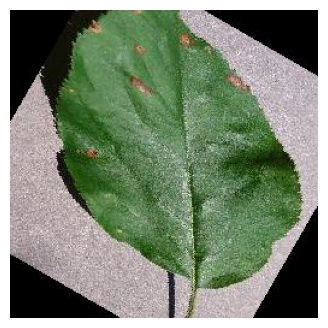

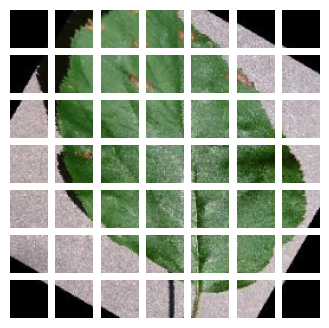

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(4, 4))

target = train_path + "/Black Rot"
random_num = random.choice(os.listdir(target))
image = mpimg.imread(train_path + "/Black Rot" + "/" + random_num)
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [13]:
image_size = 224 
img_height, img_width = 512, 512
patch_size = 16
num_patches = (image_size // patch_size) ** 2


In [14]:
 class Patches(layers.Layer):
    
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


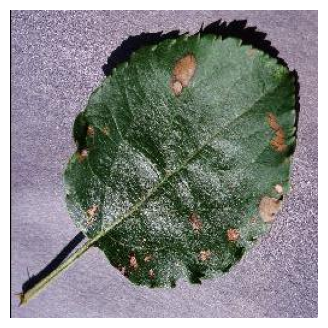

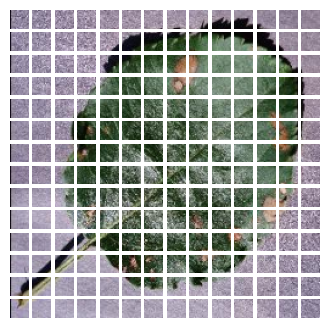

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(4, 4))

target = train_path + "/Black Rot"
random_num = random.choice(os.listdir(target))
image = mpimg.imread(train_path + "/Black Rot" + "/" + random_num)
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [16]:
image_size = 224 
img_height, img_width = 512, 512
patch_size = 8
num_patches = (image_size // patch_size) ** 2

In [17]:
 class Patches(layers.Layer):
    
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 8 X 8
Patches per image: 784
Elements per patch: 192


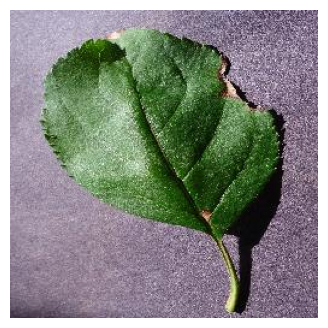

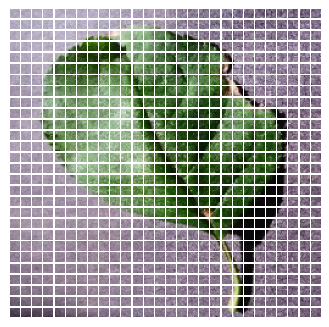

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(4, 4))

target = train_path + "/Black Rot"
random_num = random.choice(os.listdir(target))
image = mpimg.imread(train_path + "/Black Rot" + "/" + random_num)
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [19]:
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model

# # Hyperparameters
# image_size = 224  # Image size
# patch_size = 32   # Patch size
# num_patches = (image_size // patch_size) ** 2  # Number of patches per image
# embedding_dim = 256  # Dimension of embedding
# num_heads = 8  # Number of attention heads
# num_transformer_blocks = 6  # Number of transformer blocks (layers)
# mlp_dim = 512  # MLP dimension (for feedforward layers)
# num_classes = 4  # Number of classes

# # Input layer
# input_image = layers.Input(shape=(image_size, image_size, 3))

# # 1. Patch Embedding: Split the image into patches and flatten them
# def patch_embedding(x, patch_size, embedding_dim):
#     # Extract patches
#     patches = layers.Reshape(target_shape=(image_size // patch_size, patch_size, image_size // patch_size, patch_size, 3))(x)
#     patches = layers.Reshape(target_shape=(-1, patch_size * patch_size * 3))(patches)
#     # Linear embedding
#     patch_embeddings = layers.Dense(embedding_dim)(patches)
#     return patch_embeddings

# # Apply patch embedding to the input image
# patches = patch_embedding(input_image, patch_size, embedding_dim)

# # 2. Add Positional Encoding
# class PositionalEncoding(layers.Layer):
#     def __init__(self, num_patches, embedding_dim):
#         super(PositionalEncoding, self).__init__()
#         self.positional_embeddings = self.add_weight(
#             "pos_embeddings", shape=(num_patches, embedding_dim), initializer="zeros"
#         )
    
#     def call(self, x):
#         return x + self.positional_embeddings

# # Apply positional encoding to the patches
# encoded_patches = PositionalEncoding(num_patches, embedding_dim)(patches)

# # 3. Transformer Encoder
# def transformer_encoder(x, num_heads, mlp_dim):
#     # Multi-head self-attention
#     attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
#     attention_output = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
    
#     # Feed-forward network
#     ffn_output = layers.Dense(mlp_dim, activation='relu')(attention_output)
#     ffn_output = layers.Dense(embedding_dim)(ffn_output)
    
#     return layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

# # Apply several transformer blocks
# x = encoded_patches
# for _ in range(num_transformer_blocks):
#     x = transformer_encoder(x, num_heads, mlp_dim)

# # 4. Global Average Pooling
# x = layers.GlobalAveragePooling1D()(x)

# # 5. Output Layer (Dense layer for classification)
# output = layers.Dense(num_classes, activation="softmax")(x)

# # Create the model
# model = Model(inputs=input_image, outputs=output)

# # Compile the model
# model.compile(
#     loss="categorical_crossentropy",
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     metrics=["accuracy"]
# )

# # Model summary
# model.summary()


In [20]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt

# # Dataset Paths
# train_path = "/kaggle/input/plant-village-dataset-updated/Apple/Train"
# val_path = "/kaggle/input/plant-village-dataset-updated/Apple/Val"
# test_path = "/kaggle/input/plant-village-dataset-updated/Apple/Test"

# # ImageDataGenerators
# train_datagen = ImageDataGenerator(
#     rescale=1./255,  # Normalize images to [0, 1]
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator(rescale=1./255)

# # Create data generators
# train_generator = train_datagen.flow_from_directory(
#     train_path,
#     target_size=(224, 224),  # Resize images to the input size of the model
#     batch_size=32,
#     class_mode='categorical'  # Assuming multiple classes
# )

# val_generator = val_datagen.flow_from_directory(
#     val_path,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )

# # Test Generator (if needed for evaluation)
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     test_path,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )

# # You can check the number of classes to ensure correct class mappings
# num_classes = len(train_generator.class_indices)
# print("Number of classes:", num_classes)

# # Now, you can define and train your ViT model
# # Assuming you already have the ViT model created as in your previous code
# patch_sizes = [32, 16, 8]
# history_dict = {}

# # Loop over different patch sizes for training
# for patch_size in patch_sizes:
#     print(f"\nTraining with patch size: {patch_size}")
    
#     # Create the ViT model for this patch size
#     model = create_vit_model(patch_size)  # Make sure this function is defined
    
#     # Compile the model
#     model.compile(
#         loss="categorical_crossentropy",
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#         metrics=["accuracy"]
#     )

#     # Train the model using the training and validation generators
#     history = model.fit(
#         train_generator,
#         epochs=10,
#         validation_data=val_generator
#     )
    
#     # Save the history for later analysis
#     history_dict[patch_size] = history.history

#     # Plot training and validation accuracy and loss
#     plt.figure(figsize=(12, 4))

#     # Plot training & validation accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title(f"Accuracy for Patch Size {patch_size}")
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot training & validation loss
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title(f"Loss for Patch Size {patch_size}")
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.show()

# # If needed, evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Hyperparameters
image_size = 224  # Image size
embedding_dim = 256  # Dimension of embedding
num_heads = 8  # Number of attention heads
num_transformer_blocks = 6  # Number of transformer blocks (layers)
mlp_dim = 512  # MLP dimension (for feedforward layers)
num_classes = 4  # Number of classes
patch_sizes = [32, 16, 8]  # Different patch sizes

# Dataset Paths
train_path = "/kaggle/input/plant-village-dataset-updated/Apple/Train"
val_path = "/kaggle/input/plant-village-dataset-updated/Apple/Val"
test_path = "/kaggle/input/plant-village-dataset-updated/Apple/Test"

# ImageDataGenerators for loading and augmenting images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)

# Define the Vision Transformer Model
def create_vit_model(patch_size, image_size=image_size, embedding_dim=embedding_dim, num_heads=num_heads, 
                     num_transformer_blocks=num_transformer_blocks, mlp_dim=mlp_dim, num_classes=num_classes):
    # Input layer
    input_image = layers.Input(shape=(image_size, image_size, 3))

    # Patch Embedding
    def patch_embedding(x, patch_size, embedding_dim):
        patches = layers.Reshape(target_shape=(image_size // patch_size, patch_size, image_size // patch_size, patch_size, 3))(x)
        patches = layers.Reshape(target_shape=(-1, patch_size * patch_size * 3))(patches)
        patch_embeddings = layers.Dense(embedding_dim)(patches)
        return patch_embeddings

    patches = patch_embedding(input_image, patch_size, embedding_dim)

    # Positional Encoding
    class PositionalEncoding(layers.Layer):
        def __init__(self, num_patches, embedding_dim):
            super(PositionalEncoding, self).__init__()
            self.positional_embeddings = self.add_weight(
                "pos_embeddings", shape=(num_patches, embedding_dim), initializer="zeros"
            )
        
        def call(self, x):
            return x + self.positional_embeddings

    num_patches = (image_size // patch_size) ** 2
    encoded_patches = PositionalEncoding(num_patches, embedding_dim)(patches)

    # Transformer Encoder Block
    def transformer_encoder(x, num_heads, mlp_dim):
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        attention_output = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
        
        ffn_output = layers.Dense(mlp_dim, activation='relu')(attention_output)
        ffn_output = layers.Dense(embedding_dim)(ffn_output)
        
        return layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    x = encoded_patches
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, num_heads, mlp_dim)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output Layer
    output = layers.Dense(num_classes, activation="softmax")(x)

    # Create the model
    model = Model(inputs=input_image, outputs=output)
    
    return model


# Train and evaluate with different patch sizes
history_dict = {}

for patch_size in patch_sizes:
    print(f"\nTraining with patch size: {patch_size}")
    
    # Create ViT model with the specified patch size
    model = create_vit_model(patch_size)
    
    # Compile the model
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"]
    )

    # Train the model using the training and validation generators
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator
    )
    
    # Save the history for later analysis
    history_dict[patch_size] = history.history

    # Plot training and validation accuracy and loss
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy for Patch Size {patch_size}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Loss for Patch Size {patch_size}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# # Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


Found 7771 images belonging to 4 classes.
Found 1747 images belonging to 4 classes.
Found 196 images belonging to 4 classes.

Training with patch size: 32
Epoch 1/20
243/243 [==============================] - ETA: 0s - loss: 1.3393 - accuracy: 0.3615

In [ ]:
test_set = val_datagen.flow_from_directory(test_path,
                                                target_size = (224, 224),
                                                 batch_size = 64,
                                                 shuffle = False,
                                                 class_mode = 'categorical')

In [ ]:
model_2 = model  # Assign the trained model to model_2


In [ ]:
model_2 = create_vit_model(patch_size)  # Assuming 'create_vit_model' is the function you used to create the model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
import numpy as np

# Assuming 'test_set' is your test data generator and 'model' is the trained model
Y_pred = model.predict(test_set, steps=len(test_set))  # Predict class probabilities
y_pred = np.argmax(Y_pred, axis=1)  # Get the predicted class labels

# Optionally, you can compare the predicted labels with the true labels (y_true).
y_true = test_set.classes  # Assuming test_set is a Keras generator, this will give the true labels

# For example, to calculate accuracy:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy}")


In [ ]:
cf = confusion_matrix(test_set.classes, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10,8), dpi=100)
sns.set(font_scale = 1.1)

ax = sns.heatmap(cf, annot=True, fmt='d', )

ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=25)
ax.xaxis.set_ticklabels(['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=25)
ax.yaxis.set_ticklabels(['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy'])

# set plot title
ax.set_title("Confusion Matrix for Patch Size 32 ", fontsize=14, pad=20)

plt.show()

In [ ]:
print('Classification Report')
target_names = ['Apple Scab', 'Black Rot' , 'Cedar Apple Rust' , 'Healthy']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the test set
test_set = val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

# Assuming 'create_vit_model' function and patch sizes are already defined.
patch_sizes = [32, 16, 8]

for patch_size in patch_sizes:
    print(f"\nEvaluating with patch size: {patch_size}")
    
    # Create and compile the ViT model for the current patch size
    model = create_vit_model(patch_size=patch_size)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Load pre-trained weights or train the model if needed
    # model.load_weights("your_pretrained_model_weights.h5")  # If you have pre-trained weights

    # Predict using the model
    Y_pred = model.predict(test_set, steps=len(test_set))
    y_pred = np.argmax(Y_pred, axis=1)  # Convert predictions to class labels

    # Get true labels
    y_true = test_set.classes

    # Classification Report
    print("\nClassification Report:")
    target_names = ['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy']
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Confusion Matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8), dpi=100)
    sns.set(font_scale=1.1)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

    ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=25)
    ax.xaxis.set_ticklabels(target_names)
    ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=25)
    ax.yaxis.set_ticklabels(target_names)

    # Set plot title
    ax.set_title(f"Confusion Matrix for Patch Size {patch_size}", fontsize=14, pad=20)
    plt.show()


In [ ]:
# Predict on the test dataset
y_pred = model.predict(test_generator, verbose=1)

# Get the class with the highest probability (e.g., for classification)
y_pred_classes = np.argmax(y_pred, axis=1)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Generate and print classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


In [ ]:
import os

# Check overlap between datasets
train_files = set(os.listdir(train_path))
val_files = set(os.listdir(val_path))
test_files = set(os.listdir(test_path))

print("Overlap between Train and Test:", train_files & test_files)
print("Overlap between Train and Val:", train_files & val_files)
print("Overlap between Val and Test:", val_files & test_files)


In [ ]:
# Verify class indices
print("Class Indices in Test Generator:", test_generator.class_indices)
print("Unique Predicted Labels:", np.unique(predicted_labels))

# Compare alignment of predictions and ground truth
for i in range(10):
    print(f"True Label: {true_labels[i]}, Predicted Label: {predicted_labels[i]}")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_generator.classes, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)  # Remove augmentations for now


In [ ]:
import numpy as np

# Get predicted probabilities
predicted_probs = model.predict(test_generator)

# Inspect some samples
for i in range(10):
    print(f"True Label: {test_generator.classes[i]}, Predicted Probabilities: {predicted_probs[i]}")


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)
test_generator_augmented = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


In [ ]:
import matplotlib.pyplot as plt

for i in range(10):  # Show 10 misclassified samples
    if true_labels[i] != predicted_labels[i]:  # Misclassified
        img, label = test_generator[i]
        plt.imshow(img[0])
        plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
        plt.show()


In [ ]:
import matplotlib.pyplot as plt

for i, (img, label) in enumerate(test_generator):
    if true_labels[i] == 0 and predicted_labels[i] == 3:  # Misclassified as Healthy
        plt.imshow(img[0])
        plt.title(f"True: 0 (Apple Scab), Predicted: 3 (Healthy)")
        plt.show()
        break


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Get a sample misclassified image
img_path = "/path/to/misclassified/image.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Grad-CAM visualization
grad_model = Model(
    inputs=model.inputs, 
    outputs=[model.get_layer("conv5_block3_out").output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, 3]  # Target misclassified class

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.imshow(heatmap[0], cmap="viridis")
plt.title("Grad-CAM Heatmap")
plt.show()


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)
tta_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Predict with TTA
tta_predictions = []
for _ in range(10):  # Augment each image 10 times
    preds = model.predict(tta_generator)
    tta_predictions.append(preds)

# Average predictions
final_predictions = np.mean(tta_predictions, axis=0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

misclassified_idx = np.where(predicted_labels != true_labels)[0]

for idx in misclassified_idx[:5]:  # Visualize the first 5 misclassifications
    img, label = test_generator[idx]
    plt.imshow(img[0])
    plt.title(f"True: {class_names[true_labels[idx]]}, Pred: {class_names[predicted_labels[idx]]}")
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Function to plot a styled confusion matrix
def plot_styled_confusion_matrix(true_labels, predictions, patch_size, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for Patch Size {patch_size}")
    plt.show()

# Compute and display confusion matrix and classification report for each patch size
for patch_size in patch_sizes:
    print(f"\nResults for Patch Size: {patch_size}")
    
    # Assume each model is named as `model_{patch_size}` and is already trained
    model_name = f"model_{patch_size}"  # Replace with your actual model naming if different
    model = globals()[model_name]  # Retrieve the model
    
    # Reset the test generator and predict
    test_generator.reset()
    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    
    # Plot styled confusion matrix
    class_names = list(test_generator.class_indices.keys())
    plot_styled_confusion_matrix(true_labels, predicted_labels, patch_size, class_names)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))


In [ ]:
# Train the models for different patch sizes and store them in variables
model_32 = create_vit_model(patch_size=32)
model_16 = create_vit_model(patch_size=16)
model_8 = create_vit_model(patch_size=8)

# Compile the models
for model in [model_32, model_16, model_8]:
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"]
    )

# Train each model for 10 epochs (or your desired number of epochs)
history_32 = model_32.fit(train_generator, epochs=20, validation_data=val_generator)
history_16 = model_16.fit(train_generator, epochs=20, validation_data=val_generator)
history_8 = model_8.fit(train_generator, epochs=20, validation_data=val_generator)

# Now store the models in a dictionary
models = {32: model_32, 16: model_16, 8: model_8}

# Class names for the confusion matrix and classification report
class_names = list(test_generator.class_indices.keys())

# Iterate through the patch sizes and generate confusion matrices for each model
for patch_size in models.keys():
    print(f"\nConfusion Matrix for Patch Size {patch_size}")
    
    # Get the model for this patch size
    model = models[patch_size]
    
    # Predict on the test set
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for Patch Size {patch_size}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Classification Report
    print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
for patch_size, history in history_dict.items():
    print(f"Plotting for Patch Size {patch_size}...")
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy for Patch Size {patch_size}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"Loss for Patch Size {patch_size}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [ ]:
# Example of fine-tuning the learning rate
learning_rates = [0.001, 0.0001, 0.00001]

for lr in learning_rates:
    print(f"Training with learning rate {lr}...")
    model = create_vit_model(best_patch_size)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=["accuracy"]
    )
    model.fit(train_generator, epochs=20, validation_data=val_generator)


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Set up ImageDataGenerator for training, validation, and testing
# train_datagen = ImageDataGenerator(
#     rescale=1./255,  # Normalize pixel values to [0, 1]
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     train_path,
#     target_size=(224, 224),  # Resize images to match input shape of ViT
#     batch_size=32,
#     class_mode='categorical'  # Multi-class classification
# )

# val_generator = val_datagen.flow_from_directory(
#     val_path,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )

# # Fit the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=10,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size
# )


In [ ]:
# Define patch sizes you want to test
patch_sizes = [32, 16, 8]

# Store the training history for each patch size
history_dict = {}

# Loop over each patch size
for patch_size in patch_sizes:
    print(f"\nTraining with patch size: {patch_size}")

    # Define your model
    model = create_vit_model(patch_size)  # Make sure to create your ViT model for each patch size

    # Compile the model
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["accuracy"]
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator
    )

    # Save the training history
    history_dict[patch_size] = history.history

    # Plotting the training and validation accuracy and loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f"Train Accuracy {patch_size}")
    plt.plot(history.history['val_accuracy'], label=f"Val Accuracy {patch_size}")
    plt.title(f"Accuracy for Patch Size {patch_size}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f"Train Loss {patch_size}")
    plt.plot(history.history['val_loss'], label=f"Val Loss {patch_size}")
    plt.title(f"Loss for Patch Size {patch_size}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


**2. Model Construction**

In [ ]:
fe_L2 = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_r50_l32_fe/1",
                       input_shape = (224,224,3),
                       trainable = False,
                       name = "Pre_Trained_")

model_2 = tf.keras.Sequential([
    fe_L2,
    layers.Dense(128,activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(4, activation = "softmax", name = "output_layer")
])

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

In [ ]:
model_2.summary()

# Model Training

In [ ]:
epochs = 10
r=model_2.fit(train_set,
            epochs = epochs,
            validation_data = val_set,
            steps_per_epoch=len(train_set),
            validation_steps = len(val_set))


In [ ]:
import matplotlib.pyplot as plt
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = r.history['accuracy']
train_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

# Model Evaluation

In [ ]:
test_set = val_datagen.flow_from_directory(test_path,
                                                target_size = (224, 224),
                                                 batch_size = 64,
                                                 shuffle = False,
                                                 class_mode = 'categorical')


In [ ]:
Y_pred = model_2.predict(test_set, steps = len(test_set) )
y_pred = np.argmax(Y_pred, axis=1)


In [ ]:
cf = confusion_matrix(test_set.classes, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10,8), dpi=100)
sns.set(font_scale = 1.1)

ax = sns.heatmap(cf, annot=True, fmt='d', )

ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=25)
ax.xaxis.set_ticklabels(['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=25)
ax.yaxis.set_ticklabels(['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy'])

# set plot title
ax.set_title("Confusion Matrix for Apple Leaf Disease Classification ", fontsize=14, pad=20)

plt.show()

In [ ]:
print('Classification Report')
target_names = ['Apple Scab', 'Black Rot' , 'Cedar Apple Rust' , 'Healthy']
print(classification_report(test_set.classes, y_pred, target_names=target_names))